# Robust Forecasting

When outliers are present in a dataset, they can disrupt the calculated summary statistics, such as the mean and standard deviation, leading the model to favor the outlier values and deviate from most observations. Consequently, models need help in achieving a balance between accurately accommodating outliers and performing well on normal data, resulting in diminished overall performance on both types of data. To tackle this issue, we can employ robust regression algorithms that explicitly account for outliers in the dataset.

In this notebook we will show how to fit robust NeuralForecast methods. We will:<br>
- Installing NeuralForecast.<br>
- Loading Noisy AirPassengers.<br>
- Fit and predict robustified NeuralForecast.<br>
- Plot and evaluate predictions.<br>

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/Robust_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing NeuralForecast

In [ ]:
#%%capture
#!pip install neuralforecast

In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, HuberMQLoss

from neuralforecast.utils import AirPassengersDF

## 2. Loading Noisy AirPassengers

After loading the AirPassengers dataset, we will augment it by introducing outliers. 

In particular, we will focus on introducing outliers to the target variable.
We achieve this by altering to deviate from its original observation by a specified factor, such as 2-to-4 times the standard deviation.

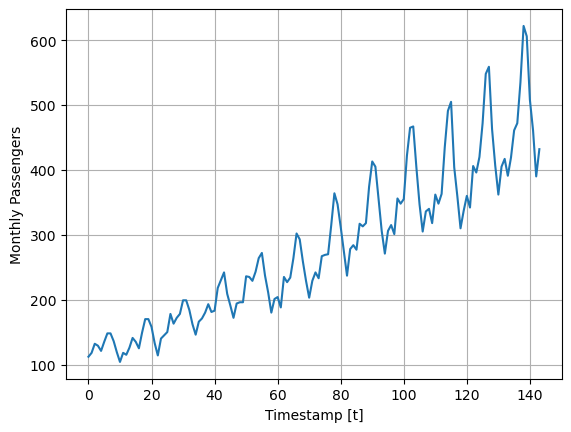

In [ ]:
# Original Box-Cox AirPassengers 
# as defined in neuralforecast.utils
Y_df = AirPassengersDF.copy() 
plt.plot(Y_df.y)
plt.ylabel('Monthly Passengers')
plt.xlabel('Timestamp [t]')
plt.grid()

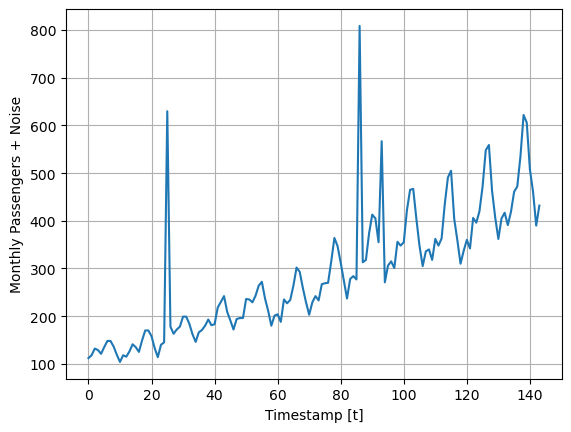

In [ ]:
from random import random
from random import randint
from random import seed

# Here we add some artificial outliers to AirPassengers
seed(1)
for i in range(len(Y_df)):
    factor = randint(2, 4)
    if random() > 0.97:
        Y_df.y[i] += factor * Y_df.y.std()

plt.plot(Y_df.y)
plt.ylabel('Monthly Passengers + Noise')
plt.xlabel('Timestamp [t]')
plt.grid()

In [ ]:
# Split datasets into train/test 
# Last 12 months for test
Y_train_df = Y_df.groupby('unique_id').head(-12).reset_index()
Y_test_df = Y_df.groupby('unique_id').tail(12).reset_index()
Y_test_df

,index,unique_id,ds,y
0,132,1.0,1960-01-31,417.0
1,133,1.0,1960-02-29,391.0
2,134,1.0,1960-03-31,419.0
3,135,1.0,1960-04-30,461.0
4,136,1.0,1960-05-31,472.0
5,137,1.0,1960-06-30,535.0
6,138,1.0,1960-07-31,622.0
7,139,1.0,1960-08-31,606.0
8,140,1.0,1960-09-30,508.0
9,141,1.0,1960-10-31,461.0


## 3. Fit and predict robustified NeuralForecast

### Huber MQ Loss

The Huber loss, employed in robust regression, is a loss function that 
exhibits reduced sensitivity to outliers in data when compared to the 
squared error loss. The Huber loss function is quadratic for small errors and linear for large 
errors. Here we will use a slight modification for probabilistic predictions. Feel free to play with the $\delta$ parameter.

![](../imgs_losses/huber_loss.png)

### Dropout Regularization

The dropout technique is a regularization method used in neural networks to prevent overfitting. During training, dropout randomly sets a fraction of the input units or neurons in a layer to zero at each update, effectively "dropping out" those units. This means that the network cannot rely on any individual unit because it may be dropped out at any time. By doing so, dropout forces the network to learn more robust and generalizable representations by preventing units from co-adapting too much.

The dropout method, can help us to robustify the network to outliers in the auto-regressive features. You can explore it through the `dropout_theta` parameter.

### Fit NeuralForecast models

Using the `NeuralForecast.fit` method you can train a set of models to your dataset. You can define the forecasting `horizon` (12 in this example), and modify the hyperparameters of the model. For example, for the `NHITS` we changed the default hidden size for both encoder and decoders.

See the `NHITS` and `MLP` [model documentation](https://nixtla.github.io/neuralforecast/models.mlp.html).

In [ ]:
%%capture
horizon = 12

# Try different hyperparmeters to improve accuracy.
models = [NHITS(h=horizon,                           # Forecast horizon
                input_size=2 * horizon,              # Length of input sequence
                loss=HuberMQLoss(level=[80,90], delta=0.5),          # Robust Huber Loss
                valid_loss=MQLoss(level=[80,90]),                    # Validation signal
                max_steps=500,                       # Number of steps to train
                dropout_prob_theta=0.6,              # Dropout to robustify vs outlier lag inputs
                #early_stop_patience_steps=2,        # Early stopping regularization patience
                val_check_steps=10,                  # Frequency of validation signal (affects early stopping)
                alias='NHITS-Huber',
              ),
          NHITS(h=horizon,
                input_size=2 * horizon,
                loss=DistributionLoss(distribution='Normal', level=[80,90]), # Classic Normal distribution
                valid_loss=MQLoss(level=[80,90]),
                max_steps=500,
                #early_stop_patience_steps=2,
                val_check_steps=10,
                alias='NHITS-Normal',
              )
          ]
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict()

Global seed set to 1
Global seed set to 1


In [ ]:
# By default NeuralForecast produces forecast intervals
# In this case the lo-x and high-x levels represent the 
# low and high bounds of the prediction accumulating x% probability
Y_hat_df = Y_hat_df.reset_index(drop=True)
Y_hat_df

,ds,NHITS-Huber-median,NHITS-Huber-lo-90,NHITS-Huber-lo-80,NHITS-Huber-hi-80,NHITS-Huber-hi-90,NHITS-Normal,NHITS-Normal-median,NHITS-Normal-lo-90,NHITS-Normal-lo-80,NHITS-Normal-hi-80,NHITS-Normal-hi-90
0,1960-01-31,418.739380,393.699493,404.838715,725.595642,871.146179,136.590683,136.975601,-79.319580,-31.350176,301.025269,354.747772
1,1960-02-29,424.246765,387.171783,396.658478,751.154419,900.300537,149.849625,152.347473,26.685875,55.349026,244.114716,269.226074
2,1960-03-31,519.390442,450.086853,463.685791,749.819824,844.686218,151.559326,150.675507,30.515121,56.763309,251.616776,280.838043
3,1960-04-30,489.352020,441.068451,449.065887,615.490906,728.639404,158.788330,158.228485,25.954943,54.072536,261.690125,291.685669
4,1960-05-31,480.117126,441.875488,449.868256,537.120422,594.418274,156.704483,158.225677,36.069668,63.636112,256.446381,279.366577
5,1960-06-30,543.143372,513.887329,522.809021,578.487122,607.924744,159.397552,159.553802,39.156567,64.291962,252.657501,278.329834
6,1960-07-31,620.444580,569.880249,582.902405,665.106506,696.823730,163.717407,165.550995,33.392715,66.574921,265.713837,293.333069
7,1960-08-31,626.729187,568.485168,582.518799,707.050110,751.402771,162.364777,162.407227,41.325619,68.595924,255.938721,279.149231
8,1960-09-30,551.085754,515.629578,520.082092,701.172302,749.540466,165.907867,165.193665,49.576164,72.942009,258.262024,280.529968
9,1960-10-31,493.817749,443.987244,453.807007,649.306274,696.087830,169.518494,168.817505,52.436401,78.577003,260.571655,287.228180


## 4. Plot and Evaluate Predictions

Finally, we plot the forecasts of both models againts the real values.

And evaluate the accuracy of the `NHITS-Huber` and `NHITS-Normal` forecasters.

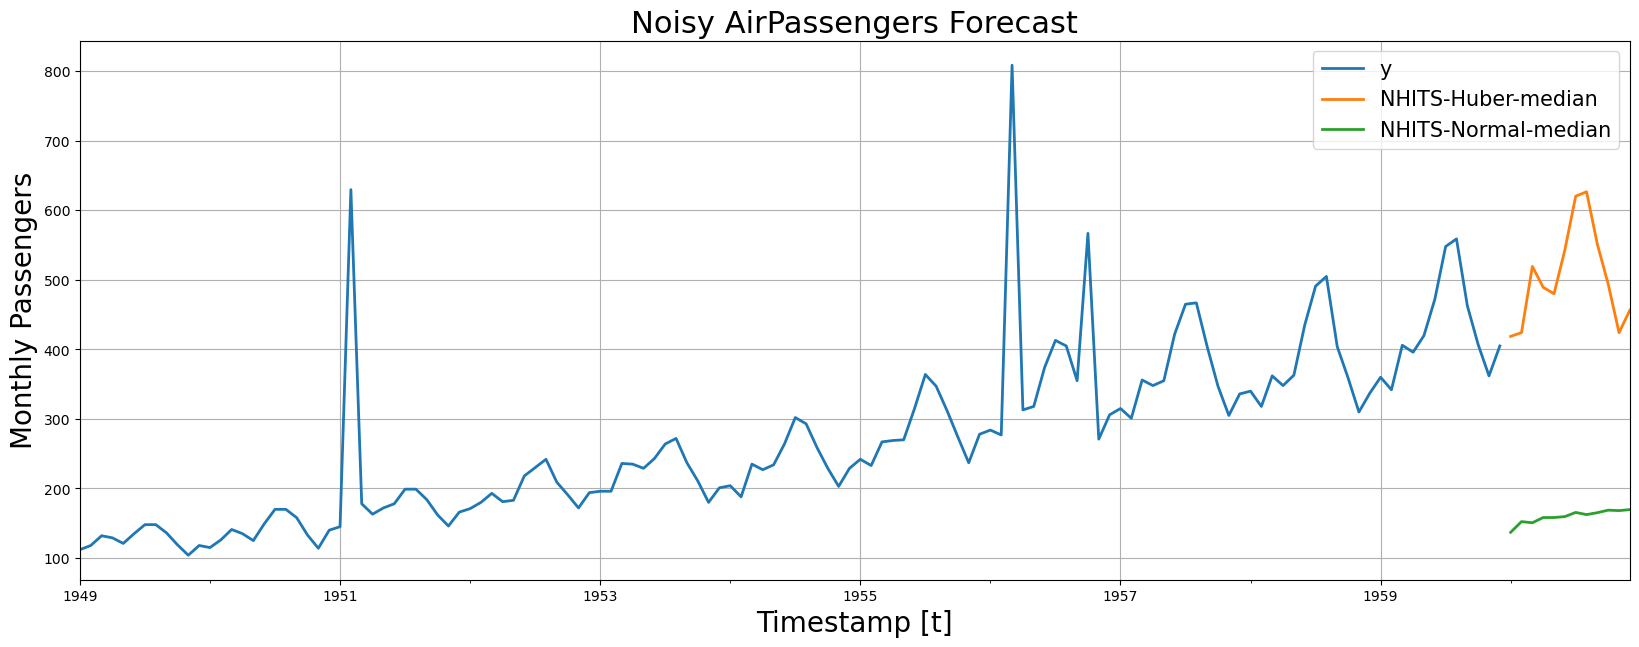

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds') # Concatenate the train and forecast dataframes
plot_df[['y', 'NHITS-Huber-median', 'NHITS-Normal-median']].plot(ax=ax, linewidth=2)

ax.set_title('Noisy AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [ ]:
def mape(y, y_hat):
    return np.mean(np.abs(y-y_hat)/np.abs(y))

huber_mae = mape(y=Y_test_df['y'], y_hat=Y_hat_df['NHITS-Huber-median'])
normal_mae = mape(y=Y_test_df['y'], y_hat=Y_hat_df['NHITS-Normal-median'])

print(f'Huber MAPE: {huber_mae:.1%}')
print(f'Normal MAPE: {normal_mae:.1%}')

Huber MAPE: 6.3%
Normal MAPE: 65.8%


## References

- [Huber Peter, J (1964). "Robust Estimation of a Location Parameter". Annals of Statistics.](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-35/issue-1/Robust-Estimation-of-a-Location-Parameter/10.1214/aoms/1177703732.full)<br>
- [Nitish Srivastava, Geoffrey Hinton, Alex Krizhevsky, Ilya Sutskever, Ruslan Salakhutdinov (2014)."Dropout: A Simple Way to Prevent Neural Networks from Overfitting". Journal of Machine Learning Research.](https://jmlr.org/papers/v15/srivastava14a.html)<br>
- [Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2023). NHITS: Neural Hierarchical Interpolation for Time Series Forecasting. Accepted at AAAI 2023.](https://arxiv.org/abs/2201.12886)